# kmeans ||

In [1]:
import time

time0 = time.time()

In [2]:
# import the python libraries to create/connect to a Spark Session
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master("spark://10.67.22.124:7077")\
    .appName("prova iniziale")\
    .config("spark.executor.memory", "2g")\
    .config("spark.driver.memory", "4g") \
    .getOrCreate()
    # .spark.conf.set("spark.executor.instances", 4)
    # .spark.conf.set("spark.executor.cores", 4)

23/09/16 17:26:59 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [3]:
spark

In [4]:
# create a spark context
sc = spark.sparkContext

# print its status
sc

<SparkContext master=spark://10.67.22.124:7077 appName=PySparkShell>

# Import data from sklern (load in the disk)

In [5]:
sc.setLogLevel("ERROR") # To hide warnings, commented to debug

In [6]:
# spark.sql.codegen.wholeStage= "false"
spark.conf.set("spark.sql.codegen.wholeStage", False)

In [7]:
# !pip install scikit-learn # to be run at the launch of "docker compose up"

In [8]:
import numpy as np
import pandas as pd
import random
import sklearn.datasets #va installato
import time
import matplotlib.pyplot as plt

from pyspark.sql.functions import sum as spark_sum
from pyspark.sql.functions import col
from pyspark.sql.functions import mean
from pyspark.sql.functions import stddev
from pyspark.sql.functions import rand
from pyspark.sql.functions import least
from pyspark.sql import Row
from pyspark.ml.feature import StandardScaler
from pyspark.sql.types import StringType

from operator import add
from functools import reduce

In [9]:
# Hyperparameters
k = 50
G = 2 # multiplying factor
len_df = 494_021

In [10]:
# # Import dataframe directly from sklearn
# prova =  sklearn.datasets.fetch_kddcup99(percent10 = True, as_frame = True)
# X = prova.data

# n_cols = len(X.iloc[0])

# n_cols = n_cols - 3 #because we will remove the binary variables

# # Create the spark dataframe with a smaller chunk of data (just to work easily)
# X_smaller = X.iloc[random.sample(range(0, len(X.index)), len_df)]
# spark_X = spark.createDataFrame(X_smaller)

# spark_X = spark_X.persist()

# Create a Spark dataframe
And then acquire important informations about the dataframe: # columns, # rows, # partitions, the schema, ...

In [11]:
%%time

#spark_X = spark.createDataFrame(sklearn.datasets.fetch_kddcup99(percent10 = True, as_frame = True)['frame'].iloc[random.sample(range(0, len_df), len_df)])
spark_X = spark.createDataFrame(sklearn.datasets.fetch_kddcup99(percent10 = True, as_frame = True)['frame'])
spark_X = spark_X.persist()

CPU times: user 1min 16s, sys: 1.43 s, total: 1min 17s
Wall time: 1min 19s


In [12]:
len_df = spark_X.count()

In [13]:
# Check the number of partitions the DataFrame is divided into the three workers yet
spark_X.rdd.getNumPartitions()

12

In [14]:
# Define a function that is able to select the single row in the dataframe
def getrows(df, rownums=None):
    return df.rdd.zipWithIndex().filter(lambda x: x[1] in rownums).map(lambda x: x[0])

In [15]:
# Delete the non-numerical values in an easy way
# clean_X = spark_X.select('*').drop('protocol_type', 'service', 'flag')
# clean_X.printSchema()

# Delete the non-numerical values in a reusable way
col_type = np.array(spark_X.dtypes)
types = col_type[:,1] 
colnames = col_type[:,0]
clean_X = spark_X.select([col(colnames[i]) for i in range(len(colnames)) if not types[i] == 'binary'])

In [16]:
# Define the number of rows and columns in the dataframe
n_rows = len_df
n_cols = len(getrows(clean_X, rownums=[0]).collect()[0])

In [17]:
n_cols

38

In [18]:
spark_X.printSchema()

root
 |-- duration: long (nullable = true)
 |-- protocol_type: binary (nullable = true)
 |-- service: binary (nullable = true)
 |-- flag: binary (nullable = true)
 |-- src_bytes: long (nullable = true)
 |-- dst_bytes: long (nullable = true)
 |-- land: long (nullable = true)
 |-- wrong_fragment: long (nullable = true)
 |-- urgent: long (nullable = true)
 |-- hot: long (nullable = true)
 |-- num_failed_logins: long (nullable = true)
 |-- logged_in: long (nullable = true)
 |-- num_compromised: long (nullable = true)
 |-- root_shell: long (nullable = true)
 |-- su_attempted: long (nullable = true)
 |-- num_root: long (nullable = true)
 |-- num_file_creations: long (nullable = true)
 |-- num_shells: long (nullable = true)
 |-- num_access_files: long (nullable = true)
 |-- num_outbound_cmds: long (nullable = true)
 |-- is_host_login: long (nullable = true)
 |-- is_guest_login: long (nullable = true)
 |-- count: long (nullable = true)
 |-- srv_count: long (nullable = true)
 |-- serror_rate: d

# Step 0: Useful functions for the initialization

In [19]:
# Define the function for the squared distance between the cluster centers and the pandas dataframe (no more used)
def distance(xrow, centers, num_cols=n_cols):
    x = np.array(xrow)[:num_cols]
    the_ds = np.zeros(len(centers))
    
    for c in range(len(centers)):
        c_array = np.array(centers[c])[:num_cols]
        dist2 = np.linalg.norm(x - c_array)**2
        the_ds[c] = dist2
        
    return np.min(the_ds)

# Euclidean distance between two rows (limited to the first n_cols)
def euclid(xrow0, xrow1, num_cols = n_cols):
    return np.linalg.norm( np.array(xrow0[0:num_cols]) - np.array(xrow1[0:num_cols]) )

# Formula to evaluate the oversamping factor with the pre-factor G
def evaluate_l(log_phi, k, G):
    return G * k/log_phi # G = over-oversampling factor

# Function to select a row based on its probability
def select_row(x):
    if x > np.random.uniform(low = 0, high = 1):
        return True
    else:
        return False


### This is NOT $\Phi$. This is $log(\Phi)$. Pay attention budeo.

# Step 1: Choose a random sample from the dataset
This is the required step to begin the algorithm (doesn't need to be parallelized, since it is a select task)

In [20]:
# Choose the first sample randomly: select the random row
random_n = [np.random.randint(0, n_rows)]
random_sample = getrows(clean_X, random_n).collect()

# Step 2: Initial cost
Then we evaluate the cost function (sum of the squares after the first selection)

In [21]:
colnames = list(clean_X.dtypes[i][0] for i in range(len(clean_X.dtypes)))

In [22]:
from pyspark.sql.functions import lit

clean_X = clean_X.withColumn("minimum_cost", lit(0))
for colname in colnames:
    clean_X = clean_X.withColumn("minimum_cost", clean_X['minimum_cost'] + (clean_X[colname]-random_sample[0][colname])**2)

In [23]:
# Add the colunm to keep the minimum distance between each point and the closest center
clean_X = (clean_X.select('*')
           .withColumn('minimum_cost', sum((col(colname)-random_sample[0][colname])**2 for colname in colnames)))

In [24]:
prova = sum((col(colname)-random_sample[0][colname])**2 for colname in colnames)

In [25]:
# Initial cost
initial_cost = np.log(clean_X.agg({"minimum_cost": "sum"}).collect()[0][0])
initial_cost

40.71877637388218

In [26]:
# Add the newly introduced value to the row that I selected in the first place
temp = random_sample[0].asDict()
temp["minimum_cost"] = 0.
random_sample[0] = Row(**temp)

In [27]:
# Broadcasting the row over the workers
bCent = sc.broadcast(random_sample)

# To show the content of the broadcast: b.value

## Step 2.5: evaluate number of iterations

After having evaluated $\log \phi$, we find a number of iterations which is of the same order of magnitude.

In [28]:
n_iter = int(initial_cost)
n_iter

40

# Step 3: For loop
Implement the for loop in order to evaluate probabilities and choose new centers



In [29]:
phi_iter = initial_cost
l = evaluate_l(phi_iter, k, G)
l

2.4558694760813577

In [30]:
%%time

i = 0
last_centers = 1
start_time = time.time()

while i < n_iter:   # or len(bCent.value) < k: # added as a safety condition (useless for very long datasets)

        '''
        Nel ciclo for:
            - Evaluate for each row l * d()^2 / phi
            - Sample with that probability
            - Broadcast centers to nodes
            - Evaluate new cost

        Ricordiamoci che distance è già al quadrato e che phi è il logaritmo
        '''

        # Evaluate the probability and select the new rows
        mod_phi = l/np.exp(phi_iter)
        new_rows = clean_X.select('*').withColumn('random_number', rand(seed=int(time.time())))\
                          .filter(col('random_number') < col('minimum_cost')*mod_phi).drop('random_number').collect()

        print("--- %s seconds ---" % (time.time() - start_time))
        start_time = time.time()
        
        # Update the broadcast in a non-usual way (newest at the beginning)
        bCent = sc.broadcast(new_rows + bCent.value)
        
        print("--- %s seconds ---" % (time.time() - start_time))
        start_time = time.time()

        # Update the minimum distance
        if len(new_rows) == 1:
            clean_X = clean_X.select('*').\
                      withColumn('minimum_cost', least('minimum_cost', reduce(add, [(col(colname)-bCent.value[0][colname])**2 for colname in colnames]))).cache()

        elif len(new_rows) > 1:
            clean_X = clean_X.select('*').withColumn('dummy', least(*[reduce(add, [(col(colname)-bCent.value[center][colname])**2 for colname in colnames]) for center in range(len(new_rows))] )).\
                      withColumn('minimum_cost', least('minimum_cost', 'dummy')).\
                      drop('dummy').cache()

        last_centers = len(bCent.value)

        # Evaluate new cost
        phi_iter = np.log(clean_X.agg({"minimum_cost": "sum"}).collect()[0][0])

        print("--- %s seconds ---" % (time.time() - start_time))
        start_time = time.time()

        i += 1

        print("\n at iteration", i ,", #values: ",len(bCent.value), " \n")

--- 1.404921293258667 seconds ---
--- 0.028487682342529297 seconds ---


--- 1.5672516822814941 seconds ---

 at iteration 1 , #values:  2  



--- 0.9930005073547363 seconds ---
--- 0.0220794677734375 seconds ---


--- 1.9102520942687988 seconds ---

 at iteration 2 , #values:  4  



--- 0.7613861560821533 seconds ---
--- 0.0180511474609375 seconds ---


--- 2.076467514038086 seconds ---

 at iteration 3 , #values:  7  



--- 0.9394772052764893 seconds ---
--- 0.017153263092041016 seconds ---


--- 1.9036519527435303 seconds ---

 at iteration 4 , #values:  9  

--- 0.8242850303649902 seconds ---
--- 0.0167081356048584 seconds ---


--- 1.9260060787200928 seconds ---

 at iteration 5 , #values:  13  



--- 0.787379264831543 seconds ---
--- 0.018697738647460938 seconds ---


--- 1.3173799514770508 seconds ---

 at iteration 6 , #values:  14  

--- 0.757577657699585 seconds ---
--- 0.016573190689086914 seconds ---


--- 2.280611038208008 seconds ---

 at iteration 7 , #values:  19  



--- 0.9133918285369873 seconds ---
--- 0.0296175479888916 seconds ---


--- 1.904432773590088 seconds ---

 at iteration 8 , #values:  22  

--- 0.7735247611999512 seconds ---
--- 0.023476839065551758 seconds ---


--- 1.4893195629119873 seconds ---

 at iteration 9 , #values:  23  

--- 0.8052210807800293 seconds ---
--- 0.02251148223876953 seconds ---


--- 1.7153818607330322 seconds ---

 at iteration 10 , #values:  26  

--- 0.8100016117095947 seconds ---
--- 0.0296018123626709 seconds ---


--- 1.950608730316162 seconds ---

 at iteration 11 , #values:  29  

--- 0.8760952949523926 seconds ---
--- 0.02424144744873047 seconds ---


--- 1.9401581287384033 seconds ---

 at iteration 12 , #values:  32  



--- 0.8938882350921631 seconds ---
--- 0.017848491668701172 seconds ---


--- 1.766831874847412 seconds ---

 at iteration 13 , #values:  34  



--- 0.8225822448730469 seconds ---
--- 0.03163886070251465 seconds ---


--- 1.724104881286621 seconds ---

 at iteration 14 , #values:  36  



--- 0.8353719711303711 seconds ---
--- 0.020951509475708008 seconds ---


--- 1.776196002960205 seconds ---

 at iteration 15 , #values:  38  



--- 0.8111367225646973 seconds ---
--- 0.005038261413574219 seconds ---


--- 1.8455779552459717 seconds ---

 at iteration 16 , #values:  40  

--- 0.8523573875427246 seconds ---
--- 0.025084257125854492 seconds ---


--- 1.7677266597747803 seconds ---

 at iteration 17 , #values:  41  

--- 0.8853473663330078 seconds ---
--- 0.004523515701293945 seconds ---


--- 2.859581708908081 seconds ---

 at iteration 18 , #values:  48  

--- 0.8458042144775391 seconds ---
--- 0.02744293212890625 seconds ---


--- 2.0347630977630615 seconds ---

 at iteration 19 , #values:  50  

--- 0.9756033420562744 seconds ---
--- 0.0228729248046875 seconds ---


--- 2.1885831356048584 seconds ---

 at iteration 20 , #values:  52  



--- 1.0622777938842773 seconds ---
--- 0.006184577941894531 seconds ---


--- 2.2665600776672363 seconds ---

 at iteration 21 , #values:  54  



--- 1.0427682399749756 seconds ---
--- 0.016583919525146484 seconds ---


--- 2.020878314971924 seconds ---

 at iteration 22 , #values:  55  

--- 0.9256877899169922 seconds ---
--- 0.01987624168395996 seconds ---


--- 2.2890889644622803 seconds ---

 at iteration 23 , #values:  57  



--- 1.0511500835418701 seconds ---
--- 0.021572113037109375 seconds ---


--- 2.4863333702087402 seconds ---

 at iteration 24 , #values:  60  

--- 1.1065237522125244 seconds ---
--- 0.0062105655670166016 seconds ---


--- 2.520017385482788 seconds ---

 at iteration 25 , #values:  64  



--- 1.121521234512329 seconds ---
--- 0.025140047073364258 seconds ---


--- 2.815260410308838 seconds ---

 at iteration 26 , #values:  68  



--- 1.1119115352630615 seconds ---
--- 0.028753042221069336 seconds ---


--- 2.6414637565612793 seconds ---

 at iteration 27 , #values:  72  



--- 1.2795436382293701 seconds ---
--- 0.008847951889038086 seconds ---


--- 2.437859058380127 seconds ---

 at iteration 28 , #values:  74  



--- 1.1057450771331787 seconds ---
--- 0.022177457809448242 seconds ---


--- 2.4351840019226074 seconds ---

 at iteration 29 , #values:  75  

--- 1.0457038879394531 seconds ---
--- 0.004904508590698242 seconds ---


--- 2.229628562927246 seconds ---

 at iteration 30 , #values:  76  

--- 1.0039873123168945 seconds ---
--- 0.007258415222167969 seconds ---


--- 2.3900246620178223 seconds ---

 at iteration 31 , #values:  78  



--- 1.1467161178588867 seconds ---
--- 0.008261442184448242 seconds ---


--- 2.54451322555542 seconds ---

 at iteration 32 , #values:  80  

--- 1.0421617031097412 seconds ---
--- 0.02032470703125 seconds ---


--- 2.6734161376953125 seconds ---

 at iteration 33 , #values:  82  



--- 1.1818280220031738 seconds ---
--- 0.010128259658813477 seconds ---


--- 2.810600519180298 seconds ---

 at iteration 34 , #values:  84  

--- 1.271212100982666 seconds ---
--- 0.020226240158081055 seconds ---
--- 1.818948745727539 seconds ---

 at iteration 35 , #values:  84  



--- 1.219897747039795 seconds ---
--- 0.015170574188232422 seconds ---


--- 2.5598456859588623 seconds ---

 at iteration 36 , #values:  86  

--- 1.1876888275146484 seconds ---
--- 0.005636692047119141 seconds ---


--- 3.0716373920440674 seconds ---

 at iteration 37 , #values:  90  

--- 1.0870294570922852 seconds ---
--- 0.011518001556396484 seconds ---


--- 2.707887649536133 seconds ---

 at iteration 38 , #values:  92  



--- 1.1724557876586914 seconds ---
--- 0.0121002197265625 seconds ---


--- 2.868823528289795 seconds ---

 at iteration 39 , #values:  94  

--- 1.223036766052246 seconds ---
--- 0.0037834644317626953 seconds ---


--- 3.5607450008392334 seconds ---

 at iteration 40 , #values:  100  

CPU times: user 3.03 s, sys: 862 ms, total: 3.89 s
Wall time: 2min 9s


for each row evaluate distance from new points --> if it's less than mindistance substitute

In [31]:
len(clean_X.where(clean_X.minimum_cost > 0).collect()) + len(clean_X.where(clean_X.minimum_cost == 0).collect())

494021

In [32]:
len(clean_X.where(clean_X.minimum_cost == 0).where(clean_X.src_bytes == 1032).collect())

198275

In [33]:
bCent.value

[Row(duration=0, src_bytes=227, dst_bytes=17372, land=0, wrong_fragment=0, urgent=0, hot=0, num_failed_logins=0, logged_in=1, num_compromised=0, root_shell=0, su_attempted=0, num_root=0, num_file_creations=0, num_shells=0, num_access_files=0, num_outbound_cmds=0, is_host_login=0, is_guest_login=0, count=4, srv_count=4, serror_rate=0.0, srv_serror_rate=0.0, rerror_rate=0.0, srv_rerror_rate=0.0, same_srv_rate=1.0, diff_srv_rate=0.0, srv_diff_host_rate=0.0, dst_host_count=4, dst_host_srv_count=255, dst_host_same_srv_rate=1.0, dst_host_diff_srv_rate=0.0, dst_host_same_src_port_rate=0.25, dst_host_srv_diff_host_rate=0.04, dst_host_serror_rate=0.0, dst_host_srv_serror_rate=0.0, dst_host_rerror_rate=0.0, dst_host_srv_rerror_rate=0.0, minimum_cost=2295288.0576),
 Row(duration=0, src_bytes=263, dst_bytes=30113, land=0, wrong_fragment=0, urgent=0, hot=0, num_failed_logins=0, logged_in=1, num_compromised=0, root_shell=0, su_attempted=0, num_root=0, num_file_creations=0, num_shells=0, num_access_f

In [34]:
clean_X.printSchema()

root
 |-- duration: long (nullable = true)
 |-- src_bytes: long (nullable = true)
 |-- dst_bytes: long (nullable = true)
 |-- land: long (nullable = true)
 |-- wrong_fragment: long (nullable = true)
 |-- urgent: long (nullable = true)
 |-- hot: long (nullable = true)
 |-- num_failed_logins: long (nullable = true)
 |-- logged_in: long (nullable = true)
 |-- num_compromised: long (nullable = true)
 |-- root_shell: long (nullable = true)
 |-- su_attempted: long (nullable = true)
 |-- num_root: long (nullable = true)
 |-- num_file_creations: long (nullable = true)
 |-- num_shells: long (nullable = true)
 |-- num_access_files: long (nullable = true)
 |-- num_outbound_cmds: long (nullable = true)
 |-- is_host_login: long (nullable = true)
 |-- is_guest_login: long (nullable = true)
 |-- count: long (nullable = true)
 |-- srv_count: long (nullable = true)
 |-- serror_rate: double (nullable = true)
 |-- srv_serror_rate: double (nullable = true)
 |-- rerror_rate: double (nullable = true)
 |-- s

# Step 4: Select a subset of the possible centroids using k-means ++

Using kmeans ++:

Algorithm 1 k-means++(k) initialization.
1: C ← sample a point uniformly at random from X
2: while |C| < k do
2
3:
Sample x ∈ X with probability dφX(x,C)
(C)
4:
C ← C ∪ {

#### Function to find closest center among list

In [35]:
# Define the function to find the closest center from any point in order to find the weights
def find_closest_center(xrow, broadC, num_cols=n_cols):
    '''Find the center in the broadcasted value 
    list whose distance from a dataframe.row 
    is the lowest:
    
    broadC = sc.broadcast(center_rows)
    xrow = clean_X.collect()[1]
    '''
    x = np.array(xrow)[:num_cols]
    centers = broadC.value
    the_ds = np.zeros(len(centers))
    
    for c in range(len(centers)):
        c_array = np.array(centers[c])[:num_cols]
        dist2 = np.linalg.norm(x - c_array)**2
        the_ds[c] = dist2
        
    return np.argmin(the_ds)

# Find minimum distance between row and all centers contained in broadcast
def find_min_euclid(xrow, broadC):
    distances = []
    for i in range(len(broadC.value)):
        distances.append(euclid(xrow, broadC.value[i]))
    return distances.index(min(distances))

In [36]:
dfCent = spark.createDataFrame(bCent.value) 

In [37]:
over_sampled_centers = dfCent.count()

In [38]:
dfCent.rdd.getNumPartitions()

12

In [39]:
len(bCent.value)

100

## Reduce size of dfCent to have only `k` centroids 

#### Step 1: calc weights $w_x$
set wx to be the number of points in X closer to x than any other point in C

In [40]:
%%time

wx = clean_X.rdd.map(lambda row: (find_min_euclid(row,bCent), 1)).\
        reduceByKey(lambda x,y: x+y).\
        takeOrdered(over_sampled_centers)

CPU times: user 41.5 ms, sys: 192 µs, total: 41.7 ms
Wall time: 38.8 s


### technical note

Now we could have a problem. During the row sampling in the `kmeans||` process, it could happen that two identical rows (for example, 3 and 40) are selected at the same loop iteration. This results in one of the two centroids not appearing in wx: all rows closest to 40 are redirected towards 3, even 40 itself. So wx has a vacancy: the sequence goes 1,2,3,4,...,38,39,41,... . In order to solve this issue, we manually add missing entries and set their value to 0. We don't need to understand whose center the missing row was a twin of: since the two are identical, the probability to select either one of them is conserved. All of this kerfuffle is just due to prevent a size error in the `rows_prob@wx` product, some cells below this line.

In [41]:
np.array(wx)[:,0]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [42]:
counter = 0
dummyCent = [(0,12),(1,12),(2,12),(4,12),(5,12),(7,12),(10,12),(11,12)]

In [43]:
while counter < len(wx):
    #print(counter)
    if wx[int(counter)][0] == counter:
        counter += 1
    else: 
        wx.insert(int(counter),(counter,0))
        counter += 1

In [44]:
wx

[(0, 422),
 (1, 487),
 (2, 514),
 (3, 539),
 (4, 750),
 (5, 1),
 (6, 6006),
 (7, 9),
 (8, 19),
 (9, 107961),
 (10, 39),
 (11, 1),
 (12, 1198),
 (13, 2401),
 (14, 1781),
 (15, 1),
 (16, 27),
 (17, 35),
 (18, 4),
 (19, 22558),
 (20, 12),
 (21, 1),
 (22, 42),
 (23, 99),
 (24, 1),
 (25, 189),
 (26, 2),
 (27, 4),
 (28, 9),
 (29, 3),
 (30, 42),
 (31, 87),
 (32, 3),
 (33, 13583),
 (34, 3),
 (35, 4),
 (36, 3),
 (37, 1),
 (38, 728),
 (39, 2708),
 (40, 372),
 (41, 2665),
 (42, 1),
 (43, 3),
 (44, 380),
 (45, 35),
 (46, 11371),
 (47, 622),
 (48, 2),
 (49, 8),
 (50, 2),
 (51, 1),
 (52, 872),
 (53, 59),
 (54, 260),
 (55, 40),
 (56, 4),
 (57, 1),
 (58, 52787),
 (59, 1),
 (60, 15),
 (61, 3890),
 (62, 1),
 (63, 1),
 (64, 175),
 (65, 2424),
 (66, 68),
 (67, 1),
 (68, 3),
 (69, 7),
 (70, 763),
 (71, 8171),
 (72, 4),
 (73, 17),
 (74, 6),
 (75, 2246),
 (76, 30),
 (77, 505),
 (78, 1815),
 (79, 34115),
 (80, 193739),
 (81, 3),
 (82, 2),
 (83, 29),
 (84, 3),
 (85, 5),
 (86, 10),
 (87, 609),
 (88, 1),
 (89, 5

In [45]:
len(wx)

100

In [46]:
wx = (np.array(wx)[:,1]).astype(float)

In [47]:
wx /= np.sum(wx)
#wx

#### Step 2: Use weighted `k-means++`
    2.1 Draw 1 random center
    2.2 update cost function
    2.3 repeat 1-2 until happy

In [48]:
# 2.1 Draw 1 random center

first_index = np.random.choice(a=range(wx.shape[0]), size=1, p=wx) 
#first point sampled uniformly wrt distance

first_index

array([58])

In [49]:
first_center = getrows(dfCent, first_index).collect()
first_center

[Row(duration=0, src_bytes=520, dst_bytes=0, land=0, wrong_fragment=0, urgent=0, hot=0, num_failed_logins=0, logged_in=0, num_compromised=0, root_shell=0, su_attempted=0, num_root=0, num_file_creations=0, num_shells=0, num_access_files=0, num_outbound_cmds=0, is_host_login=0, is_guest_login=0, count=511, srv_count=511, serror_rate=0.0, srv_serror_rate=0.0, rerror_rate=0.0, srv_rerror_rate=0.0, same_srv_rate=1.0, diff_srv_rate=0.0, srv_diff_host_rate=0.0, dst_host_count=255, dst_host_srv_count=255, dst_host_same_srv_rate=1.0, dst_host_diff_srv_rate=0.0, dst_host_same_src_port_rate=1.0, dst_host_srv_diff_host_rate=0.0, dst_host_serror_rate=0.0, dst_host_srv_serror_rate=0.0, dst_host_rerror_rate=0.0, dst_host_srv_rerror_rate=0.0, minimum_cost=262144.0)]

In [50]:
# Adds the first center to the ultimate center
bCent_ultimate = sc.broadcast(first_center)
bCent_ultimate.value

[Row(duration=0, src_bytes=520, dst_bytes=0, land=0, wrong_fragment=0, urgent=0, hot=0, num_failed_logins=0, logged_in=0, num_compromised=0, root_shell=0, su_attempted=0, num_root=0, num_file_creations=0, num_shells=0, num_access_files=0, num_outbound_cmds=0, is_host_login=0, is_guest_login=0, count=511, srv_count=511, serror_rate=0.0, srv_serror_rate=0.0, rerror_rate=0.0, srv_rerror_rate=0.0, same_srv_rate=1.0, diff_srv_rate=0.0, srv_diff_host_rate=0.0, dst_host_count=255, dst_host_srv_count=255, dst_host_same_srv_rate=1.0, dst_host_diff_srv_rate=0.0, dst_host_same_src_port_rate=1.0, dst_host_srv_diff_host_rate=0.0, dst_host_serror_rate=0.0, dst_host_srv_serror_rate=0.0, dst_host_rerror_rate=0.0, dst_host_srv_rerror_rate=0.0, minimum_cost=262144.0)]

In [51]:
# Define the total distance from other centers (minimum cost) over the chosen center
dfCent = (dfCent.select('*')
         .withColumn('minimum_cost', sum((col(colname)-first_center[0][colname])**2 for colname in colnames)))

In [52]:
# Initialize the total cost value
phi0 = np.log(dfCent.agg({"minimum_cost": "sum"}).collect()[0][0])
phi0

40.714473474896124

In [53]:
len(wx)

100

In [54]:
%%time

# 2.2 Update cost function

ultimate_sample_n = len(bCent_ultimate.value)

while ultimate_sample_n < k: #n_iter or len(bCent.value) < k:
    '''
    Nel ciclo for:
        - Evaluate for each row wx * d()^2 / phi
        - Sample with that probability
        - Broadcast centers to nodes
        - Evaluate new cost
        
    Ricordiamoci che distance è già al quadrato e che phi è il logaritmo
    '''
    
    # Evaluate the probability and select the new rows
    rows_prob = np.array(dfCent.rdd\
                .map(lambda row: distance(row,bCent_ultimate.value)).collect())
    # Forse pensare ad un modo alternativo di fare questo conto qui.... crescita lineare di bCent_ultimate
    
    # Sample new weighted random center
    another_index = np.random.choice(a=range(wx.shape[0]), size=1, p = rows_prob*wx/(rows_prob@wx) ) 
    another_center = getrows(dfCent, another_index).collect()
    
    # Update the broadcast
    bCent_ultimate = sc.broadcast(another_center + bCent_ultimate.value)

    # For consistency reason:    
    # Update minimum cost
    dfCent = dfCent.select('*').\
    withColumn('minimum_cost', least('minimum_cost', sum((col(colname)-another_center[0][colname])**2 for colname in colnames) )).cache()
    
    # Evaluate new cost
    phi0 = np.log(dfCent.agg({"minimum_cost": "sum"}).collect()[0][0])
    
    ultimate_sample_n = len(bCent_ultimate.value)
    print("i: ",ultimate_sample_n)
    

i:  2
i:  3
i:  4
i:  5
i:  6
i:  7
i:  8


i:  9
i:  10
i:  11
i:  12
i:  13
i:  14
i:  15
i:  16
i:  17
i:  18
i:  19
i:  20
i:  21
i:  22
i:  23
i:  24
i:  25
i:  26
i:  27
i:  28
i:  29
i:  30
i:  31
i:  32
i:  33
i:  34
i:  35
i:  36
i:  37
i:  38
i:  39
i:  40
i:  41
i:  42
i:  43
i:  44
i:  45
i:  46
i:  47
i:  48
i:  49
i:  50
CPU times: user 2.22 s, sys: 628 ms, total: 2.85 s
Wall time: 1min 12s


## k means

In [55]:
from pyspark.sql.functions import row_number
from pyspark.sql import Window
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql.functions import when
from pyspark.sql.functions import udf, array
from pyspark.sql.types import IntegerType


In [56]:
%%time

n = 0
phi1 = phi0
still_different = True
eps = 1e-4

while still_different:

    # # Create the weights and switch to indexed dataframe
    find_closest_udf = udf(lambda row: find_min_euclid(row, bCent_ultimate), IntegerType())
    final_df = clean_X.withColumn("closest", find_closest_udf(array([col for col in colnames]))).cache()

    # Update new centers:
    new_centers = final_df.groupBy('closest').agg(*[mean(c).alias(c) for c in colnames]).drop('closest').collect()
    bCent_ultimate = sc.broadcast(new_centers)

    # Update the minimum cost function
    clean_X = clean_X.select('*').withColumn('minimum_cost', least(*[reduce(add, [(col(colname)-new_centers[center][colname])**2 for colname in colnames]) for center in range(len(new_centers))] )).cache()

    # Evaluate new cost
    phi1 = np.log(clean_X.agg({"minimum_cost": "sum"}).collect()[0][0])
    print('Cost variation:', abs(phi1 - phi0)/phi0)
    if abs(phi1 - phi0)/phi0 < eps:
        still_different = False
    else:
        phi0 = phi1

    n += 1

    #Persist to avoid stack overflow
    clean_X = clean_X.persist()

print('It took', n, 'iterations to converge')

Cost variation: 0.05476429587527169


Cost variation: 0.0017100371613444263


Cost variation: 0.0006798293249854462


Cost variation: 0.0004528929700869104


Cost variation: 0.00033262355211496143


Cost variation: 0.00013654802340127065


Cost variation: 0.00014146098435345353


Cost variation: 0.00012088290730574853


Cost variation: 6.10037624241948e-05
It took 9 iterations to converge
CPU times: user 10.3 s, sys: 3.8 s, total: 14.1 s
Wall time: 5min 14s


In [57]:
dim1 = "dst_bytes"
dim2 = "duration"

In [58]:
src_np = clean_X.select(dim1).collect()

In [59]:
dst_np = clean_X.select(dim2).collect()

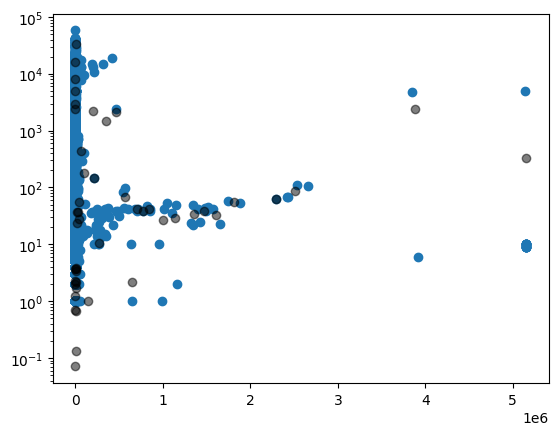

In [60]:
plt.scatter(src_np[1:], dst_np[1:])

for i in range(len(bCent_ultimate.value)):
   plt.scatter(bCent_ultimate.value[i][dim1],bCent_ultimate.value[i][dim2],color='black', alpha = 0.5)
plt.yscale('log')


In [61]:
print('final time', time.time() - time0)

final time 678.0170447826385


# TO DO:
    - Capire come scegliere l
    - Fare la normalizzazione dei dati (se la facciamo)
    - Capire se abbiamo ottimizzato nel modo giusto
    - Implementare tutto k means (optional)
    - Creare un file gemello con un dataframe visualizzabile e vedere se ha senso
    - Iniziare a fare i benchmark su cloud veneto
    - Grafici etc...

# Stop worker and master
Stop the running Spark context (sc) and Spark session (spark)

In [62]:
#sc.stop()
#spark.stop()